Vercel has a limit on the memory on the server. The bottleneck for me is sklearn. So to go around this, I'm creating from-scratch implementations of TFIDF and linear regression :-)

In [1]:
import pandas as pd
import numpy as np
# can still use the evaluation stuff for now haha
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle

<AxesSubplot:ylabel='Frequency'>

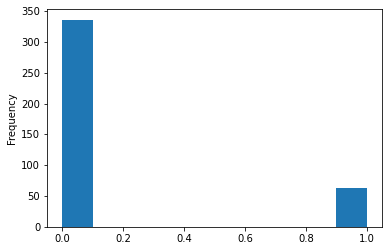

In [2]:

# load the dataset
df = pd.read_excel('Tabs Dataset.xlsx', sheet_name='Sheet2')

df['tab_name'] = df['url_and_tab_name'].apply(lambda x: x.split(' | ')[1])
df['on_topic'].fillna(0, inplace=True)
df['on_topic'].plot.hist()

This is a pretty imbalanced problem! I am not focusing much :-)

In [26]:
# Now for the from scratch implementation. I would not advice copilot or chatgpt here as it
# defeats the point, and they are also not perfect!

# Instead, follow tutorials like https://www.kaggle.com/code/yassinehamdaoui1/creating-tf-idf-model-from-scratch

class TFIDF:
    def __init__(self):
        self.documents = None
        self.vocab = None
        self.idf = None
        self.tf = None
        self.tfidf = None

    def fit(self, documents):
        self.documents = documents
        self.vocab = list(set([word for doc in documents for word in doc.split()]))
        self.idf = np.zeros(len(self.vocab))
        self.tf = np.zeros((len(self.documents), len(self.vocab)))
        self.tfidf = np.zeros((len(self.documents), len(self.vocab)))
        for i, doc in enumerate(self.documents):
            for j, word in enumerate(self.vocab):
                self.tf[i, j] = doc.split().count(word) / len(doc.split())
                if self.tf[i, j] > 0:
                    self.idf[j] += 1
        self.idf = np.log(len(self.documents) / self.idf)
        self.tfidf = self.tf * self.idf
    
    def transform(self, documents):
        tfidf = np.zeros((len(documents), len(self.vocab)))
        for i, doc in enumerate(documents):
            for j, word in enumerate(self.vocab):
                tfidf[i, j] = doc.split().count(word) / len(doc.split()) * self.idf[j]
        return tfidf
    
    def fit_transform(self, documents):
        self.fit(documents)
        return self.tfidf
    

# test the data
tfidf = TFIDF()
tfidf.fit(df['tab_name'].values)
X = tfidf.transform(df['tab_name'].values)


y = df['on_topic'].values





In [28]:
y

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0.

This worked, but as we can see, it leaves many more columns than data points in an already unbalanced dataset! 

To resolve, let's use L1 regularization on top of logistic regression.

Alternatively, we can use feature engineering to further refine the word counting above to only include alphabetic characters, try different tokenizers, etc.

In [63]:


import numpy as np

class LogisticRegression:
    
    def __init__(self, learning_rate=0.01, n_iters=10000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        # initialize weights and bias to zeros
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # gradient descent optimization
        for i in range(self.n_iters):
            # calculate predicted probabilities and cost
            z = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(z)
            cost = (-1 / n_samples) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            
            # calculate gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))            
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            # update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
    def predict(self, X,probabilities=False):
        # calculate predicted probabilities
        z = np.dot(X, self.weights) + self.bias
        y_pred = self._sigmoid(z)
        if probabilities:
            return y_pred
        
        # convert probabilities to binary predictions
        return np.round(y_pred).astype(int)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


# initialize logistic regression model
lr = LogisticRegression()

# train model on sample dataset
lr.fit(X, y)


In [64]:
predictions = lr.predict(X,probabilities=True)



In [65]:
thresh = .2
predictions[predictions > thresh] = 1
predictions[predictions <= thresh] = 0


In [66]:
df['predictions'] = predictions

In [67]:
df[df['predictions'] == 1]

,url_and_tab_name,on_topic,tab_name,predictions
1,https://huggingface.co/docs/transformers/peft ...,1.0,Load adapters with 🤗 PEFT,1.0
2,https://leetcode.com/problems/search-in-rotate...,1.0,LeetCode - The World's Leading Online Programm...,1.0
3,https://uvadlc-notebooks.readthedocs.io/en/lat...,1.0,Guide 2: Research projects with PyTorch — UvA ...,1.0
7,https://phare.health/ | Phare Health,1.0,Phare Health,1.0
8,https://www.linkedin.com/jobs/view/3732132352/...,1.0,Machine Learning Engineer,1.0
...,...,...,...,...
316,https://chat.openai.com/ | Applying for Develo...,1.0,Applying for Development Seed,1.0
319,https://www.climatechange.ai/ | Climate Change...,1.0,Climate Change AI,1.0
334,https://arxiv.org/pdf/2306.17271.pdf | Disaste...,0.0,DisasterResponseGPT: Large Language Models for...,1.0
374,https://plotly.com/ | Plotly: Low-Code Data Ap...,1.0,Plotly: Low-Code Data App Development,1.0


That should work in production! This was scratch, transferring this over to something nice now. 